[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/SatelliteVu/SatelliteVu-AWS-Disaster-Response-Hackathon/blob/main/classical_ml/logistic-regression.ipynb)

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import datasets, classifiers and performance metrics
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('data.csv')
print(f"initial df rows: {df.shape[0]}")
df.dropna(inplace=True)
all_cols = sorted(list(df.columns))

print(all_cols)

initial df rows: 59339670
['elevation_0', 'elevation_1', 'elevation_2', 'elevation_3', 'elevation_4', 'elevation_5', 'elevation_6', 'elevation_7', 'elevation_8', 'image_index', 'landcover_0', 'landcover_1', 'landcover_2', 'landcover_3', 'landcover_4', 'landcover_5', 'landcover_6', 'landcover_7', 'landcover_8', 'todays_fires_0', 'todays_fires_1', 'todays_fires_2', 'todays_fires_3', 'todays_fires_4', 'todays_fires_5', 'todays_fires_6', 'todays_fires_7', 'todays_fires_8', 'todays_frp_0', 'todays_frp_1', 'todays_frp_2', 'todays_frp_3', 'todays_frp_4', 'todays_frp_5', 'todays_frp_6', 'todays_frp_7', 'todays_frp_8', 'tomorrows_fires']


In [3]:
fire_cols = [c for c in all_cols if 'fire' in c]
fire_cols.append('image_index') # these will not be normalized
print(fire_cols)

no_fire_cols = set(all_cols).difference(set(fire_cols)) # these will be normalized
no_fire_cols

['todays_fires_0', 'todays_fires_1', 'todays_fires_2', 'todays_fires_3', 'todays_fires_4', 'todays_fires_5', 'todays_fires_6', 'todays_fires_7', 'todays_fires_8', 'tomorrows_fires', 'image_index']


{'elevation_0',
 'elevation_1',
 'elevation_2',
 'elevation_3',
 'elevation_4',
 'elevation_5',
 'elevation_6',
 'elevation_7',
 'elevation_8',
 'landcover_0',
 'landcover_1',
 'landcover_2',
 'landcover_3',
 'landcover_4',
 'landcover_5',
 'landcover_6',
 'landcover_7',
 'landcover_8',
 'todays_frp_0',
 'todays_frp_1',
 'todays_frp_2',
 'todays_frp_3',
 'todays_frp_4',
 'todays_frp_5',
 'todays_frp_6',
 'todays_frp_7',
 'todays_frp_8'}

In [4]:
hasfire_df = df[fire_cols]
nofire_df = df[no_fire_cols]

Scale the data

In [5]:
trans = StandardScaler()
df_norm = pd.DataFrame(data = trans.fit_transform(nofire_df.values), columns = nofire_df.columns) # only scaling the nofire data
df_norm = pd.concat([df_norm, hasfire_df], axis=1)

df_norm.dropna(inplace=True)
df_norm.shape

(59324610, 38)

In [6]:
## Overwrite df with normalized data
df = df_norm.copy()

/var/folders/6k/x_4lmbbn1wz1z5fw2kr_vt3h0000gn/T/ipykernel_2239/3536119419.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax=ax, bins=30);


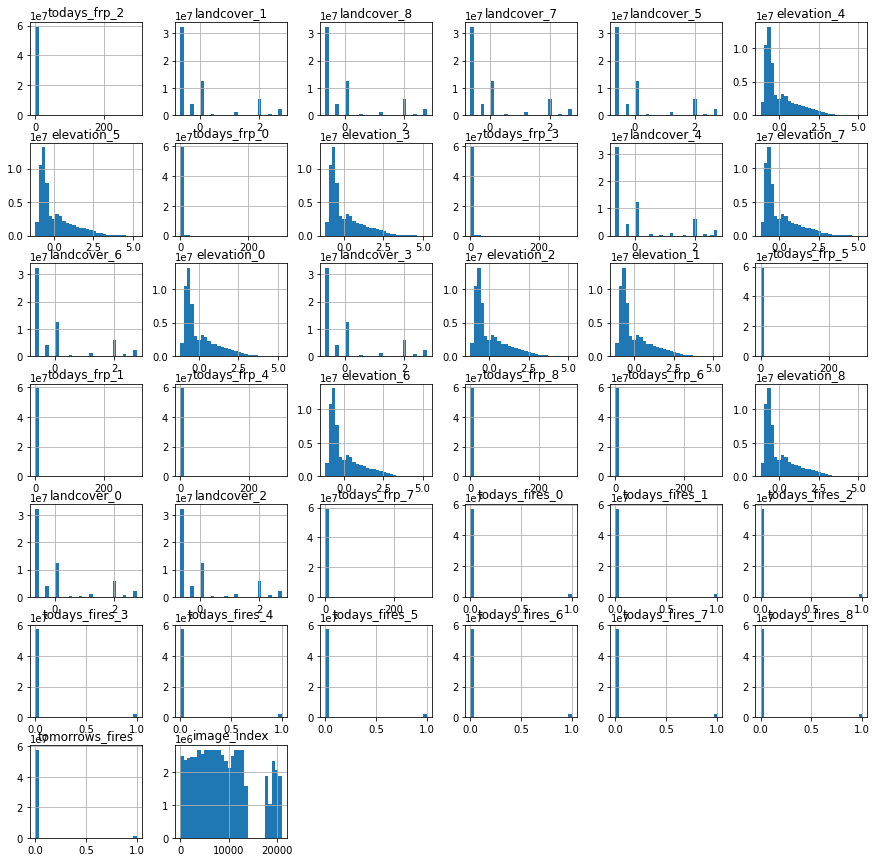

In [7]:
fig, ax = plt.subplots(figsize=(15, 15))
df.hist(ax=ax, bins=30);

## Create test/train

In [8]:
img_indexes = df['image_index'].unique()

len(img_indexes)

15434

In [9]:
train_df = df[df['image_index'].isin(img_indexes[:int(len(img_indexes) * 0.8)])]
test_df = df[df['image_index'].isin(img_indexes[-int(len(img_indexes) * 0.2):])]

In [10]:
def get_features(df: pd.DataFrame) -> tuple:
    """convenience to return features and labels"""
    try:
        df = df.drop(columns='image_index')
    except:
        pass # already dropped
    features_df = df.loc[:, df.columns != 'tomorrows_fires']
    features = features_df.values
    feature_names = list(features_df.columns)
    targets = df['tomorrows_fires'].values
    return features, targets, feature_names

X_train, y_train, feature_names = get_features(train_df)
X_test, y_test, _ = get_features(test_df)

In [11]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(47461868, 36)
(47461868,)
(11858898, 36)
(11858898,)


## Naive baseline
What we expect if we simply use the previous fire mask as prediction

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98  11602429
         1.0       0.22      0.33      0.26    256469

    accuracy                           0.96  11858898
   macro avg       0.60      0.65      0.62  11858898
weighted avg       0.97      0.96      0.96  11858898

predicted 374819 fires but true value 256469, ratio 1.4614592796790256
Confusion matrix:
[[11311152   291277]
 [  172927    83542]]


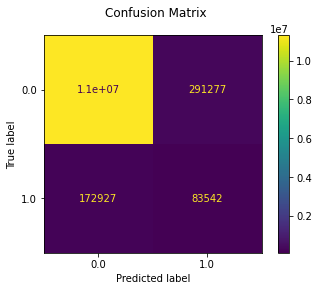

In [12]:
# Naive baseline
todays_fires_index = feature_names.index('todays_fires_4')
test_todays_fires = X_test[:, todays_fires_index].copy()
print(f"{metrics.classification_report(y_test, test_todays_fires)}")

fires_predicted = int(test_todays_fires.sum())
true_fires = int(y_test.sum())
print(f"predicted {fires_predicted} fires but true value {true_fires}, ratio {fires_predicted/true_fires}" )

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, test_todays_fires)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()


## Model training


| Fire weight  | fire precision  | fire recall | no-fire precision  | no-fire recall |
| -----------  | -----------     | ----------- | -----------        |    ----------- |
| Baseline     |      0.29       |    0.30     |      0.95          |     0.95       |
| 1            |      0.24       |    0.04     |      0.99          |     0.96       |
| 2            |      0.30       |    0.15     |      0.95          |     0.98       |
| 3            |      0.30       |    0.24     |      0.95          |     0.96       |
| 4            |      0.30       |    0.29     |      0.95          |     0.95       |
| 5            |      0.29       |    0.33     |      0.96          |     0.95       |
| 6            |      0.29       |    0.38     |      0.96          |     0.94       |
| 7            |      0.28       |    0.41     |      0.96          |     0.93       |

In [13]:
%%time
CLASS_WEIGHT = {0:1.0, 1:6.0}
model = LogisticRegression(class_weight=CLASS_WEIGHT, max_iter=1000)

# Learn the digits on the train subset
model.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = model.predict(X_test)
print(f"{metrics.classification_report(y_test, predicted)}")

## confustion matrix
fires_predicted = model.predict(X_test).sum()
true_fires = y_test.sum()
print(f"predicted {fires_predicted} fires but true value {true_fires}, ratio {fires_predicted/true_fires}" )

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

For `LogisticRegression` we can plot the coefficients:

In [ ]:
model_coeffs = {}
for row in zip(feature_names, model.coef_[0]):
    model_coeffs[row[0]] = abs(row[1])
    
model_coeffs = pd.Series(model_coeffs).sort_values(ascending=False)

model_coeffs

todays_fires_6    0.538759
todays_fires_0    0.519525
todays_fires_8    0.470137
todays_fires_2    0.467268
todays_fires_4    0.429737
todays_fires_1    0.413193
todays_fires_3    0.407976
elevation_4       0.407451
todays_fires_5    0.397985
todays_fires_7    0.392374
elevation_2       0.269129
elevation_0       0.257062
elevation_3       0.212734
elevation_5       0.114483
elevation_7       0.112677
elevation_8       0.109367
elevation_1       0.080887
landcover_4       0.047108
elevation_6       0.043628
landcover_5       0.018216
landcover_3       0.015561
landcover_7       0.011245
landcover_0       0.009732
landcover_8       0.004491
landcover_6       0.004155
landcover_2       0.002304
landcover_1       0.000232
dtype: float64